In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.signal as signal
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from astropy.stats import gaussian_sigma_to_fwhm,gaussian_fwhm_to_sigma

import datetime
import pickle
import importlib
import json
import time
import glob
import os
import re

from time_converter import time_converter
# from data.eve_const import wavelength_full,line_name,line_window,initial_guess
from gaussian_fit_eve import gaussian_fit_eve



wavelength_full = np.load('data/wavelength_full.npz')['wavelength_full']
with open('data/selected_band.pkl','rb') as f:
    selected_band = pickle.load(f)


In [3]:
selected_band

,Line Name,Wavelength Range,Initial Guess,Wavelength Index
0,X148,"[14.75, 14.93]","[0.00011, 14.84, 0.0424]","[588, 589, 590, 591, 592, 593, 594, 595, 596]"
1,X150,"[14.93, 15.09]","[4.4e-05, 15.01, 0.0424]","[597, 598, 599, 600, 601, 602, 603, 604]"
2,X152,"[15.13, 15.35]","[6.5e-05, 15.22, 0.0424]","[607, 608, 609, 610, 611, 612, 613, 614, 615, ..."
3,X154,"[15.35, 15.53]","[4e-05, 15.42, 0.0424]","[618, 619, 620, 621, 622, 623, 624, 625, 626]"
4,Fe171,"[17, 17.21]","[0.0006, 17.11, 0.0424]","[700, 701, 702, 703, 704, 705, 706, 707, 708, ..."
5,X174,"[17.37, 17.59]","[0.00069, 17.45, 0.0424]","[719, 720, 721, 722, 723, 724, 725, 726, 727, ..."
6,X176,"[17.63, 17.83]","[0.00045, 17.72, 0.0424]","[732, 733, 734, 735, 736, 737, 738, 739, 740, ..."
7,Fe180,"[17.95, 18.15]","[0.0006, 18.05, 0.0424]","[748, 749, 750, 751, 752, 753, 754, 755, 756, ..."
8,X182,"[18.15, 18.31]","[0.00013, 18.22, 0.0424]","[758, 759, 760, 761, 762, 763, 764, 765]"
9,X185,"[18.35, 18.59]","[0.0002, 18.45, 0.0424]","[768, 769, 770, 771, 772, 773, 774, 775, 776, ..."


# load in sav file data

In [3]:
eve_full_files=sorted(glob.glob('./data/EVE_sav_full/EVS_L2*.sav'))
len(eve_full_files)

36099

In [37]:
for index in selected_band.index[:12]:
    time_list=[]
    irradiance_list=[]

    #一个sav一个sav读取，因为sav加起来有250G
    for i in range(len(eve_full_files))[:]:
        eve_data=scipy.io.readsav(eve_full_files[i])

        #对于每个sav file，里面有一个小时的数据，每10s一个数据
        for j in range(len(eve_data['yyyydoy'])):
            # time
            yyyydoy=str(eve_data['yyyydoy'][j])
            sod_time=eve_data['sod_time'][j]
            
            # sc_flags : anamoly of the satellite
            sc_flag=eve_data['sc_flags'][j]
            # flag: a namoly of the instrument, ignore here first


            # irrdiance around the target spectra
            if sc_flag==0:
                irradiance=eve_data['irradiance'][j][selected_band.loc[index]['Wavelength Index']]
            else:
                irradiance=np.full(len(selected_band.loc[index]['Wavelength Index']),np.nan)

            time_list.append(time_converter(yyyydoy,sod_time))
            irradiance_list.append(irradiance)

    #construct dataframe
    original_data={
                    'time':time_list,
                    'irradiance':irradiance_list,
                    }
    original_df=pd.DataFrame(original_data)
    original_df=original_df.set_index('time')

    # save original data
    with open('./data/original_df/original_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'wb') as file:
        pickle.dump(original_df, file)

In [4]:
# select data range before MEGS-A failed
for index in selected_band.index[:1]:
    with open('./data/original_df/original_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        original_df=pickle.load(file)
    original_df=original_df[original_df.index<pd.to_datetime('2014-05-26 00:00:00')]
    
    with open('./data/original_df/original_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'wb') as file:
        pickle.dump(original_df, file)

In [5]:
# replace negative value with nan
def replace_negative_one(x):
    # x[x<0]=np.nan
    x=np.where(x<0, np.nan, x)
    return x
    
for index in selected_band.index[:1]:
    with open('./data/original_df/original_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        original_df=pickle.load(file)

    original_df['irradiance'] = original_df['irradiance'].apply(replace_negative_one)

    with open('./data/original_df/original_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'wb') as file:
        pickle.dump(original_df, file)

## Rename original_df

when indentifying some lines, (i.e. selected_band the df is mannually adjusted)
the df should be renamed instead of reading them all again.
so all we need to do is to rename the df and use it again.

In [101]:
folder_path = 'data\\original_df'
files = os.listdir(folder_path)

# Create a mapping of suffix_index to filenames
file_mapping = {}
for file in files:
    suffix_index = re.findall(r'[0-9]{3,4}', file)
    if suffix_index:
        file_mapping[suffix_index[0]] = file

file_mapping

{'977': 'original_df_C III 977.pkl',
 '171': 'original_df_Fe IX 171.pkl',
 '174': 'original_df_Fe IX 174.pkl',
 '217': 'original_df_Fe IX 217.pkl',
 '185': 'original_df_Fe X 185.pkl',
 '180': 'original_df_Fe XI 180.pkl',
 '182': 'original_df_Fe XI 182.pkl',
 '188': 'original_df_Fe XI 188.pkl',
 '187': 'original_df_Fe XII 187.pkl',
 '195': 'original_df_Fe XII 195.pkl',
 '211': 'original_df_Fe XIV 211.pkl',
 '265': 'original_df_Fe XIV 265.pkl',
 '274': 'original_df_Fe XIV 274.pkl',
 '284': 'original_df_Fe XV 284.pkl',
 '154': 'original_df_Fe XXIII 154.pkl',
 '1026': 'original_df_He I 1026.pkl',
 '584': 'original_df_He I 584.pkl',
 '950': 'original_df_He I 950.pkl',
 '972': 'original_df_He I 972.pkl',
 '304': 'original_df_He II 304.pkl',
 '625': 'original_df_Mg X 625.pkl',
 '765': 'original_df_N IV 765.pkl',
 '770': 'original_df_Ne VIII 770.pkl',
 '780': 'original_df_Ne VIII 780.pkl',
 '148': 'original_df_Ni XI 148.pkl',
 '152': 'original_df_Ni XII 152.pkl',
 '272': 'original_df_O IV 272.

#\ Solar eclipse

[[ 0  3]
 [ 3  5]
 [ 5  6]
 [ 6  7]
 [ 7  9]
 [ 9 10]]


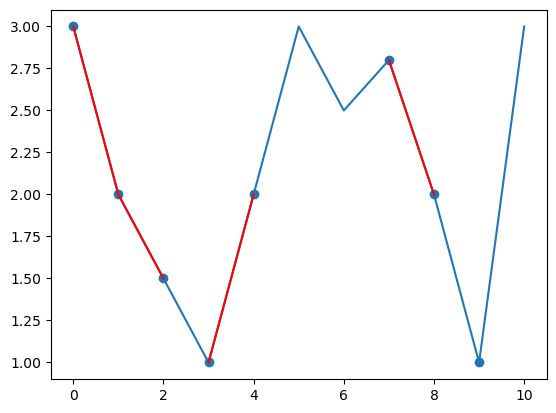

In [3]:
# data=np.array([5, 4, 3, 2, 1, np.nan, np.nan,np.nan,np.nan,1,1,1,1,1,2, 3, 4, 5,6 ])
# data=np.array([5, 4, 3, 2, 1, 1,1,1,1,1,2, 3, 4,3, 2,2.5, 1, 5 ,6])
data=np.array([3,2,1.5,1,2,3,2.5,2.8,2,1,3])
x=np.arange(len(data))

differences = np.diff(data)


# Initialize sequences list for storing only start and end indices
sequences_indices = []
sign=np.sign(differences)
sign[np.isnan(sign)]=5
diff_sign = np.diff(sign)
change_indices = np.where(diff_sign)[0]  # where the sign changes



start_index = 0
sequences_indices = []
# Iterate through change_indices to capture the sequences
# for index in change_indices:
#     # Append the sequence (start_index, end_index)
#     sequences_indices.append((start_index+1, index))
#     # Update start_index for the next sequence
#     start_index = index


for i in range(len(change_indices)):
    if i==0:
        sequences_indices.append([0,change_indices[i]+1])
    # elif i==len(change_indices)-1:
    #     sequences_indices.append([change_indices[i]+1,len(data)-1])
    else:
        sequences_indices.append([change_indices[i-1]+1,change_indices[i]+1])
        # sequences_indices.append([change_indices[i]+1,change_indices[i+1]])
    
sequences_indices.append([change_indices[-1]+1,len(data)-1])


# Convert the list of tuples to a numpy array for easier handling and manipulation
sequences_indices_np = np.array(sequences_indices)

print(sequences_indices_np)



fig,ax=plt.subplots()
ax.plot(x,data)

threshold=2
solar_eclipse_index=np.full(len(data),0)
for slice in sequences_indices_np[:]:
    if( (data[slice[0]]-threshold)*(data[slice[1]]-threshold)<0 ):
        solar_eclipse_index[slice[0]:slice[1]]=1
    ax.plot(x[slice[0]:slice[1]],data[slice[0]:slice[1]],'r')

sequences_indices_np
plt.scatter(x[solar_eclipse_index==1],data[solar_eclipse_index==1])
# ax.scatter(x[solar_eclipse_index==1],data[solar_eclipse_index==1],'g')

In [3]:
def find_solar_eclipse(data,threshold=2):
    '''
    
    '''
    differences = np.diff(data)
    sign=np.sign(differences)
    sign[np.isnan(sign)]=5
    diff_sign = np.diff(sign)
    change_indices = np.where(diff_sign)[0]  # where the sign changes

    start_index = 0
    sequences_indices = []
    for i in range(len(change_indices)):
        if i==0:
            sequences_indices.append([0,change_indices[i]+1])
        else:
            sequences_indices.append([change_indices[i-1]+1,change_indices[i]+1])
    sequences_indices.append([change_indices[-1]+1,len(data)-1])

    sequences_indices_np = np.array(sequences_indices)

    solar_eclipse_index=np.full(len(data),0)
    for slice in sequences_indices_np[:]:
        if( (data[slice[0]]-threshold)*(data[slice[1]]-threshold)<0 ):
            solar_eclipse_index[slice[0]:slice[1]]=1

    return solar_eclipse_index

In [4]:
# add a new column: eclipse_flag to the fit
for index in selected_band.index[:]:
        with open('data/original_df/original_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
                original_df=pickle.load(file)
        with open('data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
                fit_df=pickle.load(file)
                
        threshold=selected_band.loc[index]['Initial Guess'][0]*0.1
        max_irradiance=np.max(np.stack(original_df['irradiance'].values),axis=1)

        eclipse_flag_col=find_solar_eclipse(max_irradiance,threshold)
        low_flag_col=np.where(max_irradiance<threshold,1,0)
        new_flag_col=eclipse_flag_col+low_flag_col
        
        original_df['eclipse_flag']=new_flag_col
        fit_df['eclipse_flag']=new_flag_col

        #save the new df
        with open('data/original_df/original_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'wb') as file:
                pickle.dump(original_df, file)
        with open('data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'wb') as file:
                pickle.dump(fit_df, file)

In [10]:
np.where(np.array([1,2,3,4])<2.4,-999,0)

array([-999, -999,    0,    0])

In [8]:
np.size(low_flag_col)
np.sum(low_flag_col)

955

In [11]:
np.size(new_flag_col)


12678120

In [12]:
np.sum(new_flag_col)

1062

In [16]:
np.sum(np.where(max_irradiance<2*threshold,1,0))

967

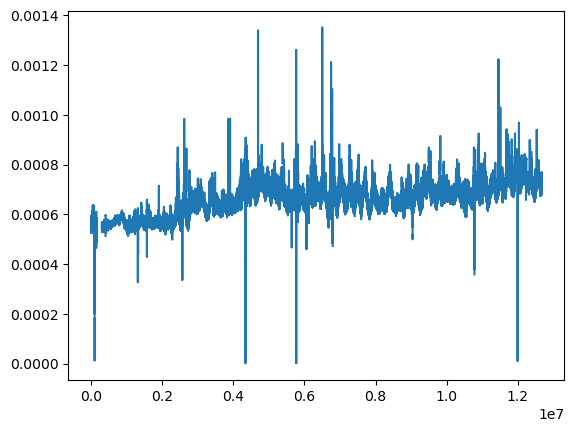

In [15]:
plt.plot(max_irradiance)

In [60]:
selected_band.loc[index]['Line Name']

'Fe X 177'

In [52]:
max_irradiance=np.max(np.stack(original_df['irradiance'].values),axis=1)
new_flag_col=find_solar_eclipse(max_irradiance,threshold=selected_band.loc[index]['Initial Guess'][0])
original_df['eclipse_flag']=new_flag_col

In [53]:
new_flag_col

array([0, 0, 0, ..., 0, 0, 0])

In [56]:
original_df['eclipse_flag']=new_flag_col

In [57]:
original_df

,irradiance,eclipse_flag
time,,
2010-04-30 00:00:00,"[1.203499e-05, 2.5988837e-05, 5.7212754e-05, 8...",0
2010-04-30 00:00:10,"[1.3617133e-05, 2.6799193e-05, 5.679315e-05, 8...",0
2010-04-30 00:00:20,"[1.2557586e-05, 2.5969795e-05, 5.813261e-05, 8...",0
2010-04-30 00:00:30,"[1.403842e-05, 2.717155e-05, 5.5758253e-05, 8....",0
2010-04-30 00:00:40,"[1.3182499e-05, 2.6641825e-05, 5.699791e-05, 8...",0
...,...,...
2014-05-25 23:59:19,"[2.0109681e-05, 3.8832823e-05, 8.0616606e-05, ...",0
2014-05-25 23:59:29,"[1.9502959e-05, 3.980035e-05, 8.3938685e-05, 0...",0
2014-05-25 23:59:39,"[2.1016278e-05, 4.073796e-05, 8.308721e-05, 0....",0


# Overview of irradiance

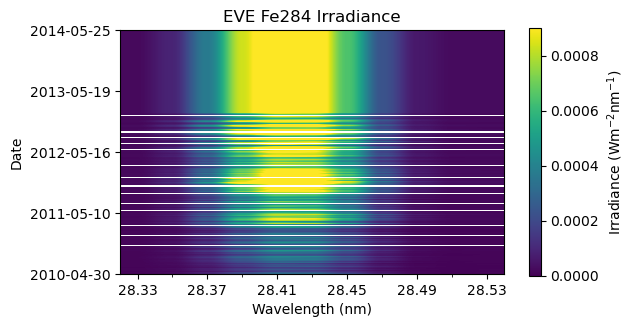

In [18]:
index=22
with open('./data/original_df/original_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        original_df=pickle.load(file)

fig,ax=plt.subplots()
irradiance=np.stack(original_df['irradiance'].values)
sc=ax.imshow(irradiance,
             aspect=5e-8 * len(selected_band.loc[index]['Wavelength Index']),
             origin='lower',
             vmax=1.5*selected_band.loc[index]['Initial Guess'][0])

ax.set_xlabel('Wavelength (nm)')
ax.set_xticks(np.arange(len(selected_band.loc[index]['Wavelength Index'])))
ax.set_xticklabels(np.round(wavelength_full[ selected_band.loc[index]['Wavelength Index'] ],2))
# add minor and major tick of x axis
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

ax.set_ylabel('Date')
ax.set_yticks(np.linspace(0,len(original_df),5))
ax.set_yticklabels([original_df.index[i].date() for i in np.linspace(0,len(original_df)-1,5).astype(int)])

ax.set_title('EVE '+selected_band.loc[index]['Line Name']+' Irradiance')

cbar = plt.colorbar(sc,shrink=0.55)
cbar.set_label(r'Irradiance ($\rm{W m^{-2} nm^{-1})}$')

plt.tight_layout()
# fig.savefig('./output/irradiance_overview/overview_irradiance_'+selected_band.loc[index]['Line Name']+'.eps'
#         #     ,dpi=1000
#             )

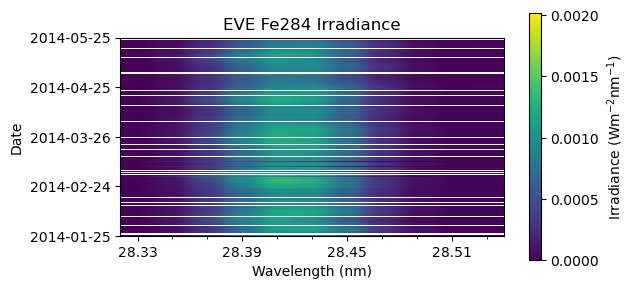

In [21]:
# show the detail of upper one, discovered that some detail in the upper figure is missing

fig,ax=plt.subplots()
irradiance=np.stack(original_df[pd.to_datetime('2014-01-25 00:00:00')<original_df.index]['irradiance'].values)
sc=ax.imshow(irradiance,
             aspect=5e-7 * len(selected_band.loc[index]['Wavelength Index']),
             origin='lower')

ax.set_xlabel('Wavelength (nm)')
# use this to set x ticklabel: ax.set_xticklabels(wavelength_full[line_window[band_index]])
ax.set_xticks(np.arange(len(selected_band.loc[index]['Wavelength Index']) ))
ax.set_xticklabels(np.round(wavelength_full[ selected_band.loc[index]['Wavelength Index'] ] ,2))

# add minor and major tick of x axis
ax.xaxis.set_major_locator(plt.MultipleLocator(3))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

ax.set_ylabel('Date')
ax.set_yticks(np.linspace(0,len(
    original_df[pd.to_datetime('2014-01-25 00:00:00')<original_df.index]
    ),5))
ax.set_yticklabels([original_df[pd.to_datetime('2014-01-25 00:00:00')<original_df.index].index[i].date() 
                for i in np.linspace(0,len(
                        original_df[pd.to_datetime('2014-01-25 00:00:00')<original_df.index])-1,5).astype(int)])

ax.set_title('EVE '+selected_band.loc[index]['Line Name']+' Irradiance')


cbar = plt.colorbar(sc,shrink=0.55)
cbar.set_label(r'Irradiance ($\rm{W m^{-2} nm^{-1})}$')

plt.tight_layout()

In [22]:
# Valid data and percentage
for index in selected_band.index[:1]:
    with open('./data/original_df/original_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        original_df=pickle.load(file)

    # Convert the 'irradiance' column to float64
    irradiance = np.stack(original_df['irradiance'].values).astype(np.float64)

    # Calculate the percentage of valid data
    valid_data_count = np.sum(irradiance > 0)
    total_data_count = irradiance.size
    valid_data_percentage = (valid_data_count / total_data_count) * 100

    print(f"{selected_band.loc[index]['Line Name']}\n valid data (above 0): {valid_data_count}\n percentage: {valid_data_percentage}% \n")


X148
 valid data (above 0): 111730635
 percentage: 97.92078794016778% 



# Fit of every 10s

In [3]:
band_index=0
with open('./data/original_df/original_df_'+line_name[band_index]+'.pkl', 'rb') as file:
    original_df = pickle.load(file)

In [5]:
original_df.iloc[0]

irradiance    [4.1993564e-05, 4.1473486e-05, 0.00012016233, ...
Name: 2010-04-30 00:00:00, dtype: object

In [26]:
gaussian_fit_eve(wavelength_full[line_window[band_index]],
                 temp,
                 initial_guess=initial_guess[band_index])

(array([nan, nan, nan]),
 array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]))

In [27]:
#对所有波段的每10s数据进行拟合，得到amplitude, mean, stddev。实际运行是分为

for index in selected_band.index[:1]:
    with open('./data/original_df/original_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        original_df=pickle.load(file)

    mean_list=[]
    stddev_list=[]
    amp_list=[]
    pcov_list=[]
    time_list=[]

    wavelength_list=wavelength_full[ selected_band.loc[index]['Wavelength Index'] ] 
    p0=selected_band.loc[index]['Initial Guess']
    i=0
    for key in original_df.index[:3]:
        # popt: fit value
        # pcov: stddev of the fit
        popt,pcov=gaussian_fit_eve(wavelength_list,
                                original_df.loc[key]['irradiance'],
                                initial_guess=p0)
        amplitude, mean, stddev=popt
        time=key  # original_df.iloc[key]['time']


        amp_list.append(amplitude)
        mean_list.append(mean)
        stddev_list.append(stddev)

        pcov_list.append(pcov)
        time_list.append(time)

        # if not np.isnan(cen):
        # print(key,cen)


        i=i+1
        if(i%86400==0):
            print(key,mean)


    fit_df={    'time':time_list,
            'amplitude':amp_list,
            'mean':mean_list,
            'stddev':stddev_list,
            'pcov':pcov_list,
            
                }
                
    fit_df=pd.DataFrame(fit_df)

    with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'wb') as file:
        pickle.dump(fit_df, file)

## Visualization of data in 10s cadence

In [17]:
# create a new df containing parameters and their errors
para_err=fit_df.apply(lambda x: np.sqrt(np.diag(x['pcov'])),axis=1)

para=fit_df[['amplitude','mean','stddev']].apply(lambda row: np.array(row), axis=1)

# create a df with para,para_err,time
para_df=pd.DataFrame({'para':para,'para_err':para_err,'time':fit_df['time']})
para_df.set_index('time',inplace=True)

In [5]:
fit_df

,time,amplitude,mean,stddev,pcov,eclipse_flag
0,2010-04-30 00:00:00,0.000093,14.843263,0.034071,"[[1.875959439078295e-12, 2.536533181338112e-12...",0
1,2010-04-30 00:00:10,0.000091,14.843349,0.034984,"[[2.627340142093762e-12, 4.771919271925031e-12...",0
2,2010-04-30 00:00:20,0.000095,14.843543,0.034208,"[[2.5711599844618505e-12, 3.385012700851381e-1...",0
3,2010-04-30 00:00:30,0.000094,14.843418,0.034212,"[[4.407363954469861e-12, 6.045004764143252e-12...",0
4,2010-04-30 00:00:40,0.000091,14.843883,0.035256,"[[2.4888259561637906e-12, 4.460716533992554e-1...",0
...,...,...,...,...,...,...
12678115,2014-05-25 23:59:19,0.000128,14.842887,0.034996,"[[6.628019857376246e-12, 9.32247591803547e-12,...",0
12678116,2014-05-25 23:59:29,0.000129,14.841991,0.034788,"[[5.969941724379643e-12, 9.003095737828829e-12...",0
12678117,2014-05-25 23:59:39,0.000129,14.842423,0.035214,"[[5.338886685860692e-12, 8.546473541461241e-12...",0
12678118,2014-05-25 23:59:49,0.000127,14.843183,0.035297,"[[4.608094416725219e-12, 6.793446036247477e-12...",0


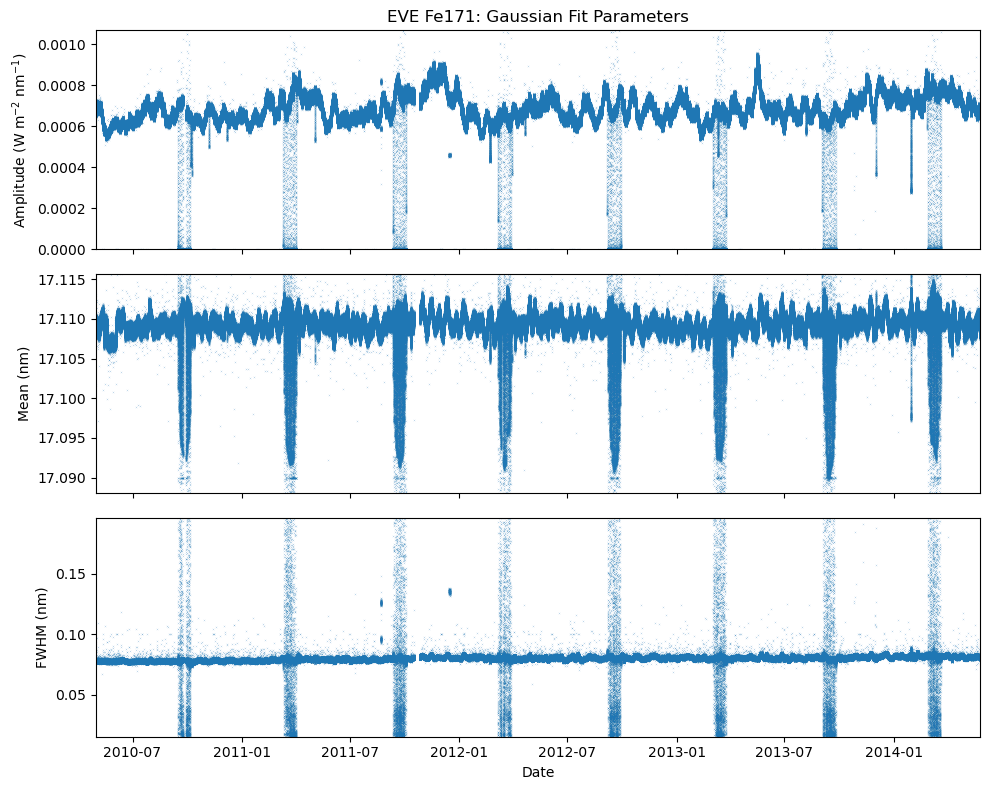

In [20]:
# 3 row 1 column    plot the parameter in 10 s cadence


fig,axs=plt.subplots(3,1,
                     figsize=(10,8),
                     sharex=True,)

axs[0].scatter(para_df.index,np.stack(para_df['para'].values)[:, 0],s=0.003,marker='x',label='amplitude')
# axs[0].scatter(para_df['time'],np.stack(para_df['para_err'].values)[:, 0],s=0.003,marker='x',label='amplitude_err')
axs[0].set_ylabel('Amplitude (W m$^{-2}$ nm$^{-1}$)')

upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 0],99.9)
axs[0].set_ylim(0.,1.2*upper_percentile)

axs[1].scatter(para_df.index,np.stack(para_df['para'].values)[:, 1],s=0.003,marker='x',label='mean')
# axs[1].scatter(para_df['time'],np.stack(para_df['para_err'].values)[:, 1],s=0.003,marker='x',label='mean_err')
axs[1].set_ylabel('Mean (nm)')
upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],99.8)
lower_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],0.1)
axs[1].set_ylim(lower_percentile,upper_percentile+0.1*(upper_percentile-lower_percentile))

axs[2].scatter(para_df.index,gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],s=0.003,marker='x',label='stddev')
# axs[2].scatter(para_df['time'],np.stack(para_df['para_err'].values)[:, 2],s=0.003,marker='x',label='stddev_err')
axs[2].set_ylabel('FWHM (nm)')
upper_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],99.95)
lower_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],0.05)
axs[2].set_ylim(lower_percentile,upper_percentile)

axs[2].set_xlabel('Date')
# axs[2].set_xlim(para_df['time'].iloc[0],para_df['time'].iloc[-1])

axs[0].set_title('EVE '+ selected_band.loc[index]['Line Name'] +': Gaussian Fit Parameters')

axs[0].set_xlim(para_df.index[0],para_df.index[-1])
    
plt.tight_layout()
fig.savefig('output/cadence_10s/cadence_10s_'+selected_band.loc[index]['Line Name']+'.png'
            # dpi=400
            )

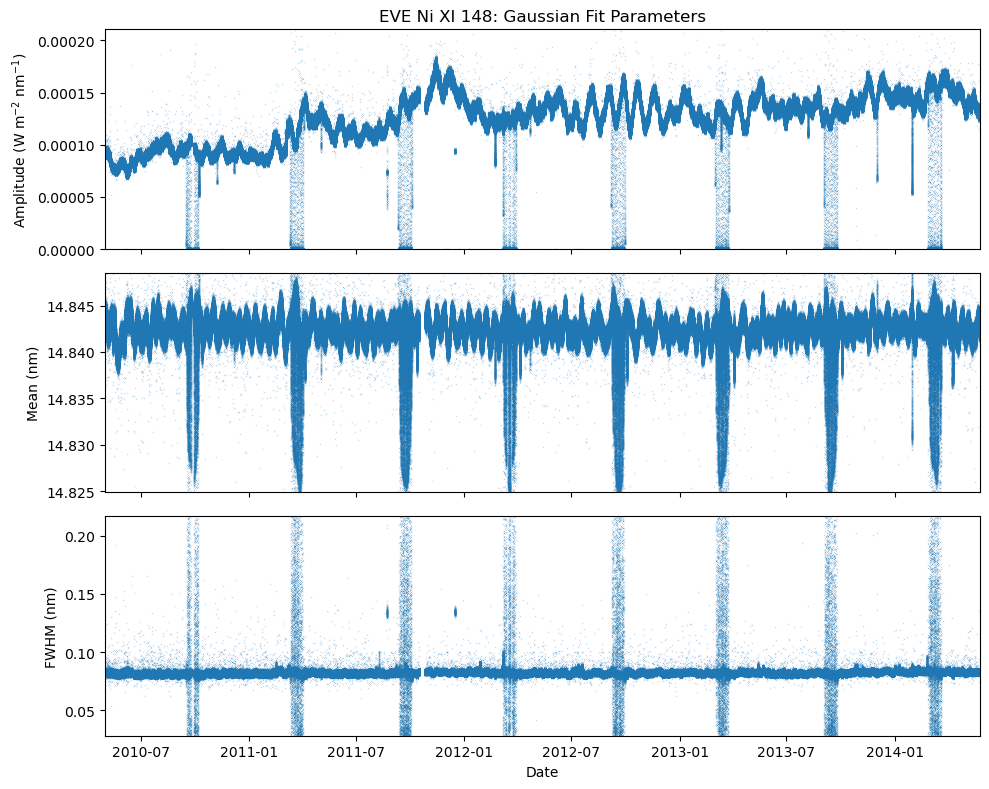

In [4]:
for index in selected_band.index[:1]:
    with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        fit_df=pickle.load(file)

        
    para_err=fit_df.apply(lambda x: np.sqrt(np.diag(x['pcov'])),axis=1)
    para=fit_df[['amplitude','mean','stddev']].apply(lambda row: np.array(row), axis=1)

    # create a df with para,para_err,time
    para_df=pd.DataFrame({'para':para,'para_err':para_err,'time':fit_df['time']})
    para_df.set_index('time',inplace=True)
    
    fig,axs=plt.subplots(4,1,
                    figsize=(10,8),
                    sharex=True,)

    axs[0].scatter(para_df.index,np.stack(para_df['para'].values)[:, 0],s=0.003,marker='x',label='amplitude')
    # axs[0].scatter(para_df['time'],np.stack(para_df['para_err'].values)[:, 0],s=0.003,marker='x',label='amplitude_err')
    axs[0].set_ylabel('Amplitude (W m$^{-2}$ nm$^{-1}$)')

    upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 0],99.9)
    axs[0].set_ylim(0.,1.2*upper_percentile)

    axs[1].scatter(para_df.index,np.stack(para_df['para'].values)[:, 1],s=0.003,marker='x',label='mean')
    # axs[1].scatter(para_df['time'],np.stack(para_df['para_err'].values)[:, 1],s=0.003,marker='x',label='mean_err')
    axs[1].set_ylabel('Mean (nm)')
    upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],99.8)
    lower_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],0.1)
    axs[1].set_ylim(lower_percentile,upper_percentile+0.1*(upper_percentile-lower_percentile))

    axs[2].scatter(para_df.index,gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],s=0.003,marker='x',label='stddev')
    # axs[2].scatter(para_df['time'],np.stack(para_df['para_err'].values)[:, 2],s=0.003,marker='x',label='stddev_err')
    axs[2].set_ylabel('FWHM (nm)')
    upper_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],99.95)
    lower_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],0.05)
    axs[2].set_ylim(lower_percentile,upper_percentile)

    axs[2].set_xlabel('Date')
    # axs[2].set_xlim(para_df['time'].iloc[0],para_df['time'].iloc[-1])

    axs[0].set_title('EVE '+ selected_band.loc[index]['Line Name'] +': Gaussian Fit Parameters')

    axs[0].set_xlim(para_df.index[0],para_df.index[-1])
        
    plt.tight_layout()
    # fig.savefig('output/cadence_10s/cadence_10s_'+ selected_band.loc[index]['Line Name'] +'.png'
    #             # dpi=400
    #             )
    
    # # close the figure
    # plt.close(fig)

### errors of fit

c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


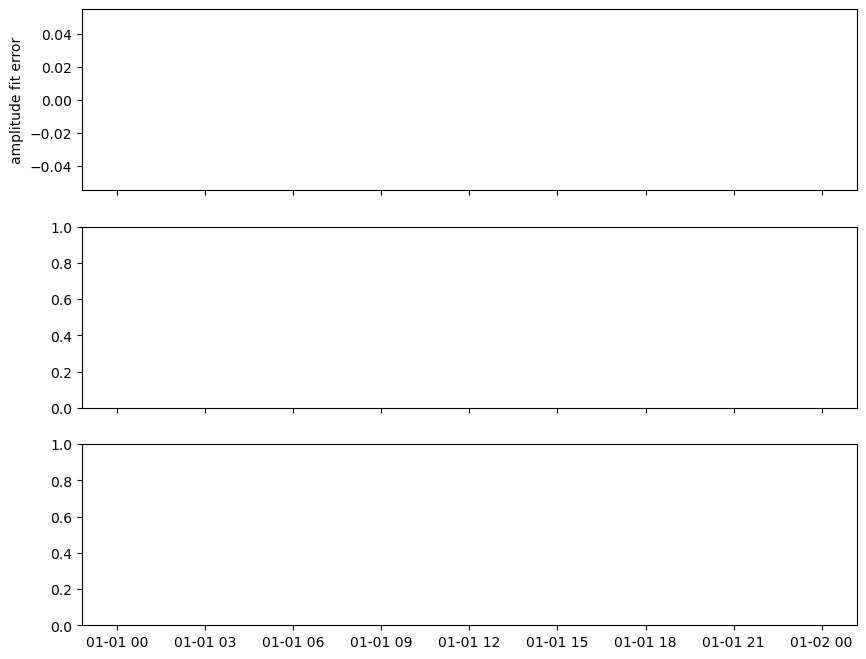

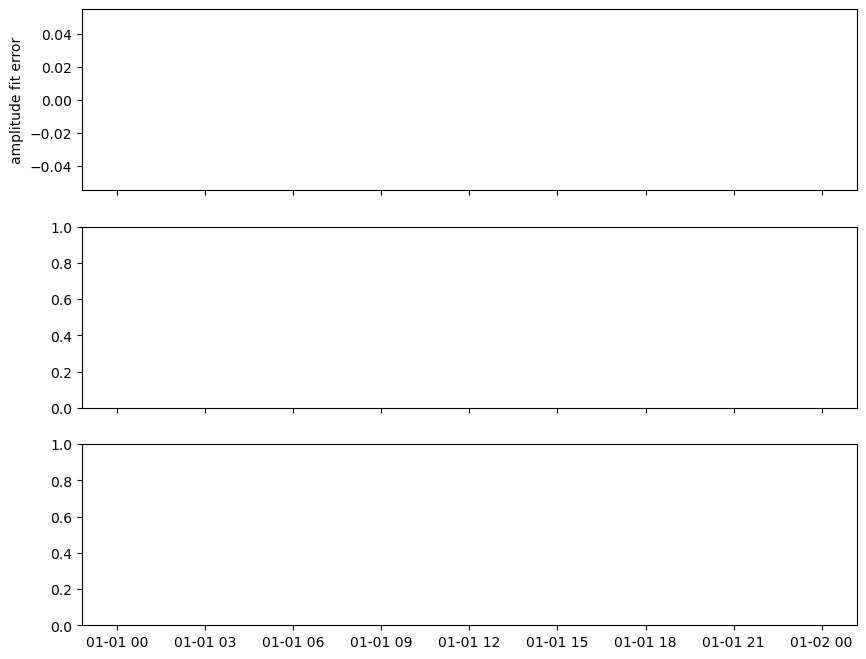

In [6]:
for index in selected_band.index[:]:
    with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        fit_df=pickle.load(file)
    
    try:
        # draw the fitting error, if the 99 percentile number is not nan or inf

        para_err=fit_df.apply(lambda x: np.sqrt(np.diag(x['pcov'])),axis=1)
        para=fit_df[['amplitude','mean','stddev']].apply(lambda row: np.array(row), axis=1)

        # create a df with para,para_err,time
        para_df=pd.DataFrame({'para':para,'para_err':para_err,'time':fit_df['time']})
        para_df.set_index('time',inplace=True)


        fig,axs=plt.subplots(3,1,figsize=(10,8),sharex=True,)
        # axs[0].scatter(para_df['time'],np.stack(para_df['para'].values)[:, 0],marker='x',label='amplitude')
        axs[0].scatter(para_df.index,np.stack(para_df['para_err'].values)[:, 0],s=0.3,marker='x',label='amplitude_err')
        axs[0].set_ylabel('amplitude fit error')

        upper_percentile=np.nanpercentile(np.stack(para_df['para_err'].values)[:, 0],99.9)
        axs[0].set_ylim(0,4*upper_percentile)

        # axs[1].scatter(para_df['time'],np.stack(para_df['para'].values)[:, 1],marker='x',label='mean')
        axs[1].scatter(para_df.index,np.stack(para_df['para_err'].values)[:, 1],s=0.3,marker='x',label='mean_err')
        axs[1].set_ylabel('mean fit error')

        upper_percentile=np.nanpercentile(np.stack(para_df['para_err'].values)[:, 1],99)
        axs[1].set_ylim(0,3*upper_percentile)


        # axs[2].scatter(para_df['time'],np.stack(para_df['para'].values)[:, 2],marker='x',label='stddev')
        axs[2].scatter(para_df.index,np.stack(para_df['para_err'].values)[:, 2],s=0.3,marker='x',label='stddev_err')
        axs[2].set_ylabel('stddev fit error')

        upper_percentile=np.nanpercentile(np.stack(para_df['para_err'].values)[:, 2],99)
        axs[2].set_ylim(0,3*upper_percentile)

        axs[2].set_xlabel('Date')
        axs[0].set_title('EVE '+selected_band.loc[index]['Line Name']+': Gaussian Fit Error')
        axs[0].set_xlim(para_df.index[0],para_df.index[-1])
        plt.tight_layout()
        plt.savefig('output/cadence_10s/fitting_error/fit_err_'+selected_band.loc[index]['Line Name']+'.png')
        # close the figure
        plt.close(fig)
    
    # if the figure is not successfully drawn, just skip
    except:
        
        pass
    

## rename fit_df

In [4]:
folder_path = 'data\\fit_10s'
files = os.listdir(folder_path)

# Create a mapping of suffix_index to filenames
file_mapping = {}
for file in files:
    suffix_index = re.findall(r'[0-9]{3,4}', file)
    if suffix_index:
        file_mapping[suffix_index[0]] = file
    
for line_name in selected_band['Line Name'].values:
    suffix_index = re.findall(r'[0-9]{3,4}', line_name)
    if suffix_index and suffix_index[0] in file_mapping:
        old_file = file_mapping[suffix_index[0]]
        new_file = "fit_10s_"+f'{line_name}.pkl'
        os.rename(os.path.join(folder_path, old_file), os.path.join(folder_path, new_file))
        print(f'rename {old_file} to {new_file}.pkl')

# for old_file in files:
#     suffix_index = re.findall(r'[0-9]{3,4}', old_file)
#     if suffix_index and (suffix_index[0] in file_mapping):
#         new_file = "original_df_"+file_mapping[suffix_index[0]]
#         os.rename(os.path.join(folder_path, old_file), os.path.join(folder_path, new_file))
#         # print(suffix_index,suffix_index[0])
#         print(f'rename {old_file} to {new_file}')


rename fit_10s_Ni XI 148.pkl to fit_10s_Ni XI 148.pkl.pkl
rename fit_10s_O VI 150.pkl to fit_10s_O VI 150.pkl.pkl
rename fit_10s_Ni XII 152.pkl to fit_10s_Ni XII 152.pkl.pkl
rename fit_10s_Fe XXIII 154.pkl to fit_10s_Fe XXIII 154.pkl.pkl
rename fit_10s_Fe IX 171.pkl to fit_10s_Fe IX 171.pkl.pkl
rename fit_10s_Fe IX 174.pkl to fit_10s_Fe IX 174.pkl.pkl
rename fit_10s_Fe X 177.pkl to fit_10s_Fe X 177.pkl.pkl
rename fit_10s_Fe XI 180.pkl to fit_10s_Fe XI 180.pkl.pkl
rename fit_10s_Fe XI 182.pkl to fit_10s_Fe XI 182.pkl.pkl
rename fit_10s_Fe X 185.pkl to fit_10s_Fe X 185.pkl.pkl
rename fit_10s_Fe XII 187.pkl to fit_10s_Fe XII 187.pkl.pkl
rename fit_10s_Fe XI 188.pkl to fit_10s_Fe XI 188.pkl.pkl
rename fit_10s_Unindentified 190.pkl to fit_10s_Unindentified 190.pkl.pkl
rename fit_10s_Fe XII 195.pkl to fit_10s_Fe XII 195.pkl.pkl
rename fit_10s_Fe XIV 211.pkl to fit_10s_Fe XIV 211.pkl.pkl
rename fit_10s_Fe IX 217.pkl to fit_10s_Fe IX 217.pkl.pkl
rename fit_10s_Unindentified 242.pkl to fit_10s_

## add a new col to fit_10s df

# Aggregate from 10s to 1 day

## deleting the data during solar eclipse
taking advantage of 'eclipse flag'

In [5]:
def f(x):
    y=np.size(x)-np.sum(np.isnan(x))
    return y
        
for index in selected_band.index[:]:
    with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        fit_df = pickle.load(file)
    fit_df.set_index('time',inplace=True)

    # delete the data during the solar eclipse
    fit_df['amplitude']=np.where(fit_df['eclipse_flag'].values==0,fit_df['amplitude'].values,np.nan)
    fit_df['mean']=np.where(fit_df['eclipse_flag'].values==0,fit_df['mean'].values,np.nan)
    fit_df['stddev']=np.where(fit_df['eclipse_flag'].values==0,fit_df['stddev'].values,np.nan)

    stddev_of_mean=fit_df['mean'].resample('D').agg(np.nanstd)
    stddev_of_stddev=fit_df['stddev'].resample('D').agg(np.nanstd)
    stddev_of_amplitude=fit_df['amplitude'].resample('D').agg(np.nanstd)
    available_data=fit_df['amplitude'].resample('D').agg(f)


    columns_to_agg = ['amplitude', 'mean', 'stddev']
    daily_median = fit_df[columns_to_agg].resample('D').agg(np.nanmedian)

    # Create a new DataFrame 'daily_fit_df' to store the daily median, stddev, and amplitude
    # fwhm=2.3*stddev
    daily_df = pd.DataFrame()
    daily_df['median_of_mean'] = daily_median['mean']
    daily_df['median_of_stddev'] = daily_median['stddev']
    daily_df['median_of_amplitude'] = daily_median['amplitude']

    daily_df['stddev_of_mean']=stddev_of_mean
    daily_df['stddev_of_stddev']=stddev_of_stddev
    daily_df['stddev_of_amplitude']=stddev_of_amplitude

    daily_df['available_data']=available_data

    # save daily_df
    with open('./data/daily_df/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'wb') as file:
        pickle.dump(daily_df, file) 


## no deletion of data during solar eclipse

In [6]:
def f(x):
    y=np.size(x)-np.sum(np.isnan(x))
    return y
        
for index in selected_band.index[:]:
    with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        fit_df = pickle.load(file)
    fit_df.set_index('time',inplace=True)
    
    # no delete the data during the solar eclipse

    stddev_of_mean=fit_df['mean'].resample('D').agg(np.nanstd)
    stddev_of_stddev=fit_df['stddev'].resample('D').agg(np.nanstd)
    stddev_of_amplitude=fit_df['amplitude'].resample('D').agg(np.nanstd)
    available_data=fit_df['amplitude'].resample('D').agg(f)


    columns_to_agg = ['amplitude', 'mean', 'stddev']
    daily_median = fit_df[columns_to_agg].resample('D').agg(np.nanmedian)

    # Create a new DataFrame 'daily_fit_df' to store the daily median, stddev, and amplitude
    # fwhm=2.3*stddev
    daily_df = pd.DataFrame()
    daily_df['median_of_mean'] = daily_median['mean']
    daily_df['median_of_stddev'] = daily_median['stddev']
    daily_df['median_of_amplitude'] = daily_median['amplitude']

    daily_df['stddev_of_mean']=stddev_of_mean
    daily_df['stddev_of_stddev']=stddev_of_stddev
    daily_df['stddev_of_amplitude']=stddev_of_amplitude

    daily_df['available_data']=available_data

    # save daily_df
    with open('./data/daily_df/no_eclipse_process/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'wb') as file:
        pickle.dump(daily_df, file) 


## add a Doppler

In [2]:
index=35
with open('./data/daily_df/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        daily_df=pickle.load(file)

In [3]:
selected_band.loc[index]['Line Name']

'N IV 765'

## Inspect Doppler

In [14]:
for index in selected_band.index[:]:
    with open('./data/daily_df/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        daily_df=pickle.load(file)


    fig,ax=plt.subplots(figsize=(10,6))
    ax.plot(daily_df['available_data'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Available Data')
    # add a dashed line at y=8640
    ax.axhline(y=8640, color='orange', linestyle='--',label='Maximum Available Data')
    ax.set_title('Available Data Every Day')
    ax.legend()
    ax.set_xlim(daily_df.index[0],daily_df.index[-1])
    plt.tight_layout()
    fig.savefig('output/available_data/available_data_'+selected_band.loc[index]['Line Name']+'.png'
                # dpi=400
                )
    
    plt.close(fig)

In [14]:
np.average(daily_df['available_data'])

1435.4156018829858

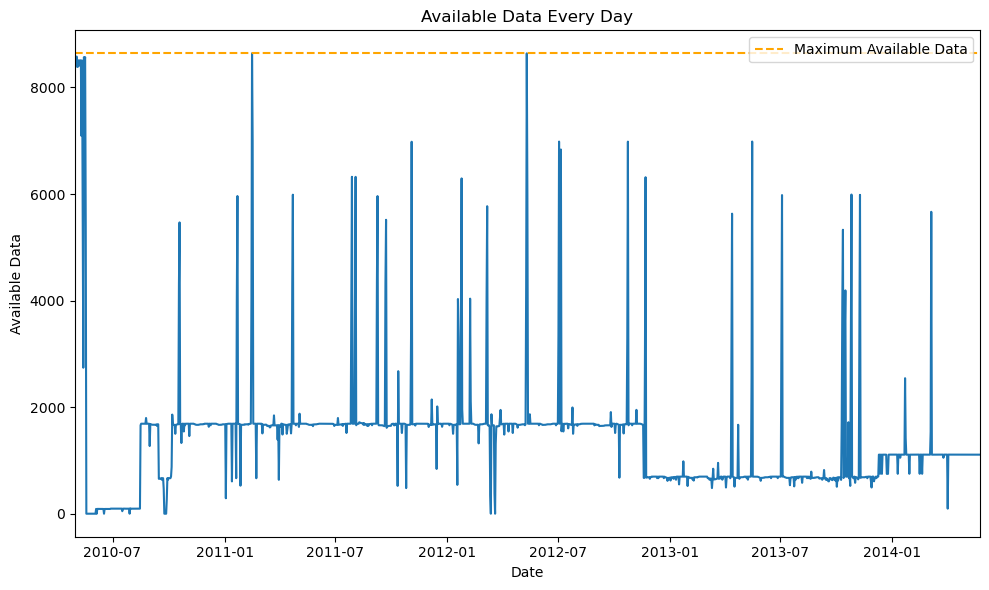

In [4]:
(daily_df['median_of_mean']/(selected_band.loc[index]['Accurate Wavelength']/10)-1.)

time
2010-04-30    0.000413
2010-05-01    0.000418
2010-05-02    0.000408
2010-05-03    0.000373
2010-05-04    0.000338
                ...   
2014-05-21    0.000379
2014-05-22    0.000397
2014-05-23    0.000396
2014-05-24    0.000378
2014-05-25    0.000348
Freq: D, Name: median_of_mean, Length: 1487, dtype: float64

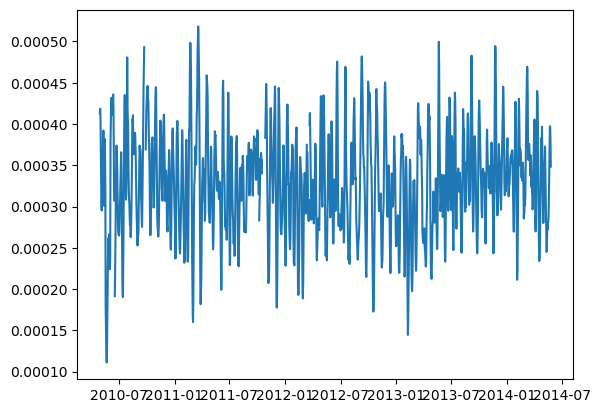

In [5]:
plt.plot((daily_df['median_of_mean']/(selected_band.loc[index]['Accurate Wavelength']/10)-1.))

In [26]:
for index in selected_band.index[:]:
    with open('./data/daily_df/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        daily_df=pickle.load(file)

    daily_df['median_of_doppler']=(daily_df['median_of_mean']/(selected_band.loc[index]['Accurate Wavelength']/10)-1.)*const.c.to('m/s').value

    with open('./data/daily_df/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'wb') as file:
        pickle.dump(daily_df, file)

# Draft

In [3]:
index=10
with open('./data/daily_df/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
    daily_df = pickle.load(file)

In [4]:
daily_df

,median_of_mean,median_of_stddev,median_of_amplitude,stddev_of_mean,stddev_of_stddev,stddev_of_amplitude,available_data,median_of_doppler
time,,,,,,,,
2010-04-30,18.685730,0.039993,0.000126,0.000467,0.000448,0.000002,8570,-47642.423668
2010-05-01,18.685568,0.040200,0.000127,0.000471,0.000424,0.000002,8579,-50235.807718
2010-05-02,18.685166,0.040109,0.000130,0.000551,0.000439,0.000002,8579,-56688.805785
2010-05-03,18.684102,0.039645,0.000131,0.000579,0.000430,0.000002,8640,-73754.162558
2010-05-04,18.683523,0.039256,0.000132,0.000463,0.000451,0.000002,8578,-83041.544856
...,...,...,...,...,...,...,...,...
2014-05-21,18.686076,0.037681,0.000211,0.000463,0.000381,0.000003,8581,-42085.227729
2014-05-22,18.686170,0.037703,0.000207,0.000470,0.000393,0.000003,8582,-40590.362289
2014-05-23,18.686074,0.037719,0.000207,0.000476,0.000383,0.000003,8582,-42124.263986


In [22]:
daily_df['median_of_doppler']=(daily_df['median_of_mean']/(selected_band.loc[index]['Accurate Wavelength']/10)-1.)*const.c.to('m/s').value

In [23]:
daily_df

,median_of_mean,median_of_stddev,median_of_amplitude,stddev_of_mean,stddev_of_stddev,stddev_of_amplitude,available_data,median_of_doppler
time,,,,,,,,
2010-04-30,14.843828,0.034806,0.000092,0.000490,0.000408,0.000001,8570,123821.232990
2010-05-01,14.843909,0.035025,0.000092,0.000511,0.000412,0.000002,8579,125449.239586
2010-05-02,14.843748,0.035044,0.000094,0.000537,0.000401,0.000002,8579,122198.735216
2010-05-03,14.843235,0.035025,0.000093,0.000531,0.000430,0.000002,8640,111832.854427
2010-05-04,14.842713,0.034927,0.000093,0.000612,0.000485,0.000002,8578,101289.962949
...,...,...,...,...,...,...,...,...
2014-05-21,14.843327,0.035119,0.000134,0.000435,0.000341,0.000002,8581,113684.989018
2014-05-22,14.843595,0.035075,0.000132,0.000505,0.000344,0.000002,8582,119098.110069
2014-05-23,14.843579,0.035045,0.000132,0.000466,0.000344,0.000002,8582,118775.975461


$$
\frac{\Delta \lambda}{\lambda} = \frac{v}{c}

$$